In [2]:
import numpy as np
import pandas as pd
import json as json
import re
import nltk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

/Users/benmischeck/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/benmischeck/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Import xlsx file with pre-cleaned ideas from survey 
df_survey_ideas = pd.read_csv("XXXX/Survey_ideas_clean.csv")

# Filter df to continue only with needed columns
columns_to_select = ['Response ID','ideas', 'idea_diversity', 'idea_clean_diversity', 'GroupAssignment', 'Task1_ChatGPT_Access', 'Task1_ChatGPT_Interaction','DAT_score','BusinessFamilarity', 'EngExp','InnoMgmtExp','SustainabilityExp', 'GenAIExp', 'GenAIFrequency', 'Age', 'Gender', 'Education', 'Employment', 'ProfField']
df_survey_ideas = df_survey_ideas[columns_to_select]

In [ ]:
# Import pre-cleaned ChatGPT results
df_chatgpt = pd.read_csv("XXXXX/chatgpt_survey_responses_cleaned.csv")

# Concat the survey results
df_ideas_1 = df_survey_ideas
df_ideas_1['idea_source'] = df_ideas_1['GroupAssignment'].apply(lambda x: "Human" if x in ['Human_Human	', 'Human_Human/AI'] else "HumanAI")
df_ideas_1 = df_ideas_1[['idea_source', 'idea_diversity','idea_clean_diversity']]
df_ideas_2 = df_chatgpt
df_ideas_2['idea_source'] = "AI"
df_ideas_2 = df_ideas_2[['idea_source', 'idea_diversity','idea_clean_diversity']]

df_ideas = pd.concat([df_ideas_1, df_ideas_2], ignore_index=True)

display(df_ideas)

,idea_source,idea_diversity,idea_clean_diversity
0,HumanAI,0.706341,0.706341
1,HumanAI,0.859799,0.883710
2,HumanAI,0.799780,0.799780
3,Human,0.806431,0.805793
4,HumanAI,0.808871,0.808871
...,...,...,...
150,AI,0.790480,0.805124
151,AI,0.774195,0.813028
152,AI,0.822086,0.830970
153,AI,0.785099,0.813229


In [5]:
# Compute average diversity scores for all groups
idea_diversity = df_ideas.groupby('idea_source')['idea_diversity'].mean()
idea_clean_diversity = df_ideas.groupby('idea_source')['idea_clean_diversity'].mean()

print("Idea diversity:", idea_diversity)
print("Idea diversity of cleaned ideas:", idea_clean_diversity)

Idea diversity: idea_source
AI         0.798556
Human      0.830673
HumanAI    0.810901
Name: idea_diversity, dtype: float64
Idea diversity of cleaned ideas: idea_source
AI         0.816804
Human      0.834442
HumanAI    0.826312
Name: idea_clean_diversity, dtype: float64


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_23491/62190841.py:21: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:gray'` for the same effect.

  sns.stripplot(data=df_melted, x='idea_source', y='Score', hue='Diversity Type',


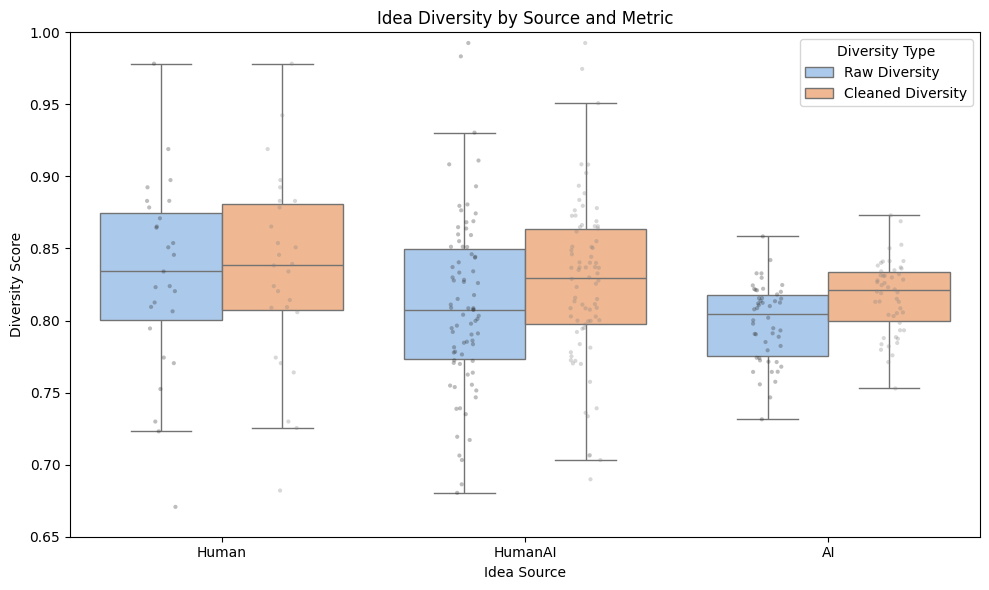

In [6]:
# Reorder idea_source as a categorical variable
category_order = ['Human', 'HumanAI', 'AI']
df_ideas['idea_source'] = pd.Categorical(df_ideas['idea_source'], categories=category_order, ordered=True)

# Melt the dataframe
df_melted = df_ideas.melt(id_vars='idea_source', 
                    value_vars=['idea_diversity', 'idea_clean_diversity'],
                    var_name='Diversity Type', 
                    value_name='Score')

# Change label names accrodingly
df_melted['Diversity Type'] = df_melted['Diversity Type'].replace({
    'idea_diversity': 'Raw Diversity',
    'idea_clean_diversity': 'Cleaned Diversity'
})

# Plot with spacing and order
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='idea_source', y='Score', hue='Diversity Type',
            palette='pastel', showfliers=False, dodge=True)
sns.stripplot(data=df_melted, x='idea_source', y='Score', hue='Diversity Type',
              dodge=True, jitter=True, size=3, alpha=0.3, color='gray')

# Remove duplicated legend entries
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Diversity Type')
plt.title('Idea Diversity by Source and Metric')
plt.xlabel('Idea Source')
plt.ylabel('Diversity Score')
plt.ylim(0.65, 1.0)
plt.tight_layout()
plt.show()


In [7]:
# Calcualte correlation
correlation = df_survey_ideas["idea_diversity"].corr(df_survey_ideas["Task1_ChatGPT_Access"])
print(f"Correlation between cosine similarity and Task1_ChatGPT_Access: {correlation:.3f}")

# Define OLS Model
X = df_survey_ideas["idea_diversity"]
X = sm.add_constant(X)  # Adds an intercept term
y = df_survey_ideas["Task1_ChatGPT_Access"]
model = sm.OLS(y, X).fit()

print(model.summary())

Correlation between cosine similarity and Task1_ChatGPT_Access: -0.330
                             OLS Regression Results                             
Dep. Variable:     Task1_ChatGPT_Access   R-squared:                       0.109
Model:                              OLS   Adj. R-squared:                  0.100
Method:                   Least Squares   F-statistic:                     12.58
Date:                  Sat, 12 Apr 2025   Prob (F-statistic):           0.000589
Time:                          22:21:36   Log-Likelihood:                -70.039
No. Observations:                   105   AIC:                             144.1
Df Residuals:                       103   BIC:                             149.4
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

Correlation between ChatGPT access (Task 1) and idea diversity: -0.330
                            OLS Regression Results                            
Dep. Variable:         idea_diversity   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     12.58
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           0.000589
Time:                        22:21:36   Log-Likelihood:                 149.53
No. Observations:                 105   AIC:                            -295.1
Df Residuals:                     103   BIC:                            -289.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

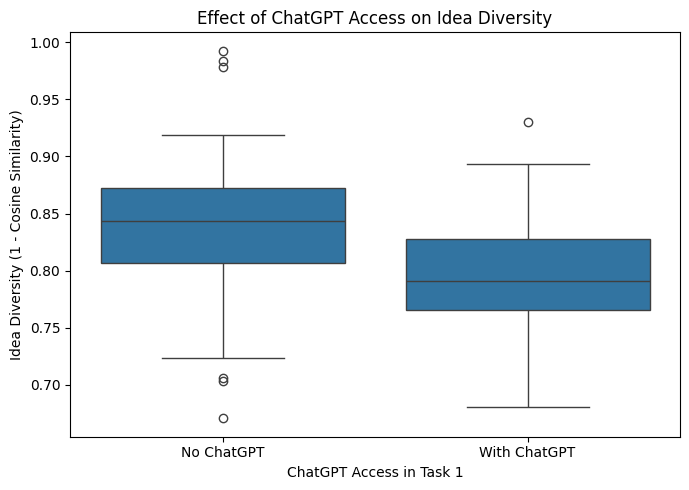

In [8]:
# Diversity + Task1_Access
# compute correlation
correlation = df_survey_ideas["idea_diversity"].corr(df_survey_ideas["Task1_ChatGPT_Access"])
print(f"Correlation between ChatGPT access (Task 1) and idea diversity: {correlation:.3f}")

# define OLS model
X = df_survey_ideas["Task1_ChatGPT_Access"] 
X = sm.add_constant(X)
y = df_survey_ideas["idea_diversity"]
model = sm.OLS(y, X).fit()

print(model.summary())

# plot for differences between experimental groups
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Access", y="idea_diversity", data=df_survey_ideas)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Access in Task 1")
plt.ylabel("Idea Diversity (1 - Cosine Similarity)")
plt.title("Effect of ChatGPT Access on Idea Diversity")
plt.tight_layout()
plt.show()


Correlation between ChatGPT access (Task 1) and idea diversity: -0.366
                            OLS Regression Results                            
Dep. Variable:         idea_diversity   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     15.90
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           0.000125
Time:                        22:21:36   Log-Likelihood:                 151.01
No. Observations:                 105   AIC:                            -298.0
Df Residuals:                     103   BIC:                            -292.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

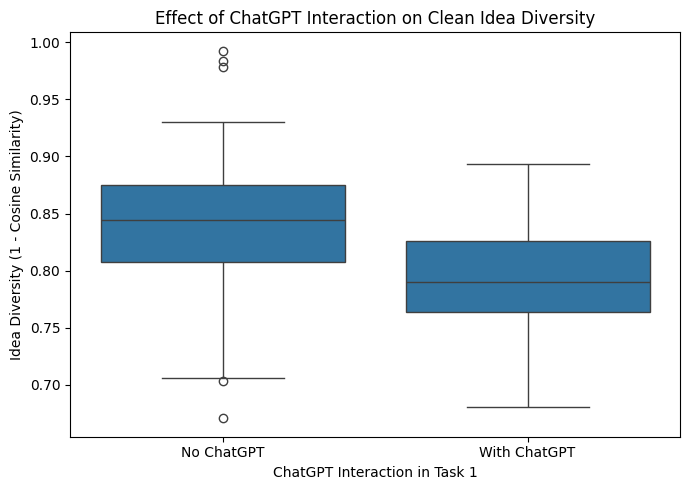

In [9]:
# Diversity + Task1_Interaction
# compute correlation
correlation = df_survey_ideas["idea_diversity"].corr(df_survey_ideas["Task1_ChatGPT_Interaction"])
print(f"Correlation between ChatGPT access (Task 1) and idea diversity: {correlation:.3f}")

# define OLS model
X = df_survey_ideas["Task1_ChatGPT_Interaction"] 
X = sm.add_constant(X)
y = df_survey_ideas["idea_diversity"]
model = sm.OLS(y, X).fit()

print(model.summary())

# plot for differences between experimental groups
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Interaction", y="idea_diversity", data=df_survey_ideas)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 1")
plt.ylabel("Idea Diversity (1 - Cosine Similarity)")
plt.title("Effect of ChatGPT Interaction on Clean Idea Diversity")
plt.tight_layout()
plt.show()


Correlation between ChatGPT access (Task 1) and idea diversity (cleaned): -0.210
                             OLS Regression Results                             
Dep. Variable:     idea_clean_diversity   R-squared:                       0.044
Model:                              OLS   Adj. R-squared:                  0.035
Method:                   Least Squares   F-statistic:                     4.737
Date:                  Sat, 12 Apr 2025   Prob (F-statistic):             0.0318
Time:                          22:21:36   Log-Likelihood:                 150.63
No. Observations:                   105   AIC:                            -297.3
Df Residuals:                       103   BIC:                            -291.9
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------

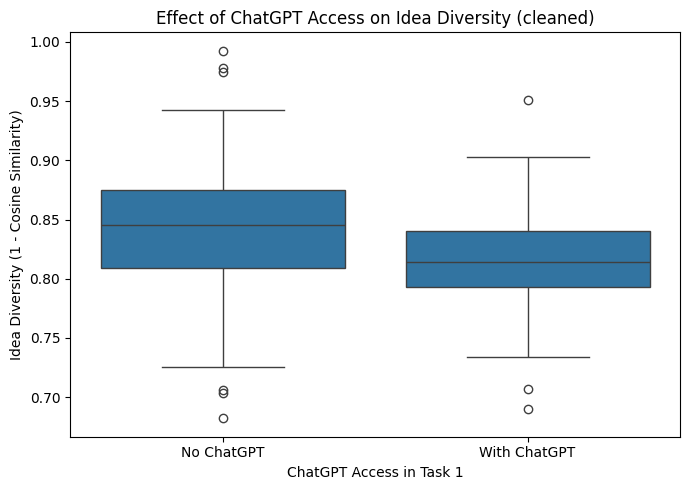

In [10]:
# Cleaned Diversity + Task1_Access
# compute correlation
correlation = df_survey_ideas["idea_clean_diversity"].corr(df_survey_ideas["Task1_ChatGPT_Access"])
print(f"Correlation between ChatGPT access (Task 1) and idea diversity (cleaned): {correlation:.3f}")

# define OLS model
X = df_survey_ideas["Task1_ChatGPT_Access"]  
X = sm.add_constant(X)
y = df_survey_ideas["idea_clean_diversity"]
model = sm.OLS(y, X).fit()

print(model.summary())

# plot for differences between experimental groups
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Access", y="idea_clean_diversity", data=df_survey_ideas)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Access in Task 1")
plt.ylabel("Idea Diversity (1 - Cosine Similarity)")
plt.title("Effect of ChatGPT Access on Idea Diversity (cleaned)")
plt.tight_layout()
plt.show()


Correlation between ChatGPT access (Task 1) and idea diversity (cleaned): -0.250
                             OLS Regression Results                             
Dep. Variable:     idea_clean_diversity   R-squared:                       0.062
Model:                              OLS   Adj. R-squared:                  0.053
Method:                   Least Squares   F-statistic:                     6.841
Date:                  Sat, 12 Apr 2025   Prob (F-statistic):             0.0102
Time:                          22:21:37   Log-Likelihood:                 151.64
No. Observations:                   105   AIC:                            -299.3
Df Residuals:                       103   BIC:                            -294.0
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------

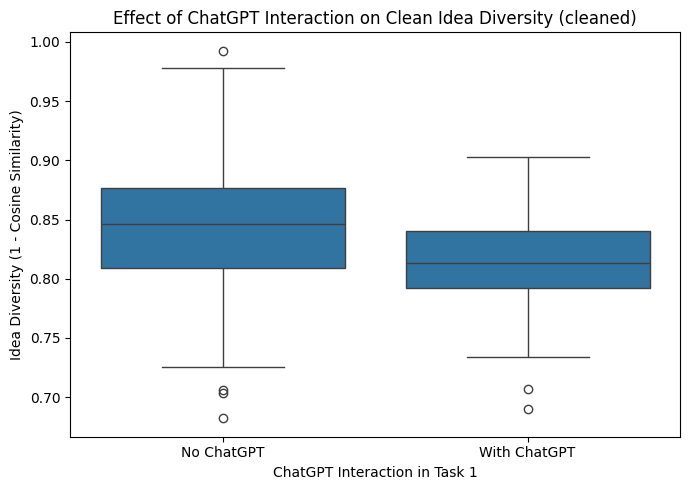

In [11]:
# Cleaned Diversity + Task1_Interaction
# compute correlation
correlation = df_survey_ideas["idea_clean_diversity"].corr(df_survey_ideas["Task1_ChatGPT_Interaction"])
print(f"Correlation between ChatGPT access (Task 1) and idea diversity (cleaned): {correlation:.3f}")

# define OLS model
X = df_survey_ideas["Task1_ChatGPT_Interaction"]  
X = sm.add_constant(X)
y = df_survey_ideas["idea_clean_diversity"]
model = sm.OLS(y, X).fit()

print(model.summary())

# plot for differences between experimental groups
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Interaction", y="idea_clean_diversity", data=df_survey_ideas)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 1")
plt.ylabel("Idea Diversity (1 - Cosine Similarity)")
plt.title("Effect of ChatGPT Interaction on Clean Idea Diversity (cleaned)")
plt.tight_layout()
plt.show()


In [12]:
# dummy encoding of all relevant control variables
df_survey_ideas['BusinessFamiliarity_High'] = df_survey_ideas['BusinessFamilarity'].apply(lambda x: 1 if x in ['Very familiar', 'Extremely familiar'] else 0)
df_survey_ideas['EngExp_High'] = df_survey_ideas['EngExp'].apply(lambda x: 1 if x in ['Near-Native (C2)', 'Native'] else 0)
df_survey_ideas['ProfField_Business'] = df_survey_ideas['ProfField'].apply(lambda x: 1 if x in ['Business, Economics, & Management'] else 0)
df_survey_ideas['InnoMgmtExp_High'] = df_survey_ideas['InnoMgmtExp'].apply(lambda x: 1 if x in ['Practical experience', 'Professional experience'] else 0)
df_survey_ideas['SustainabilityExp_High'] = df_survey_ideas['SustainabilityExp'].apply(lambda x: 1 if x in ['Practical experience', 'Professional experience'] else 0)
df_survey_ideas['GenAIExp_High'] = df_survey_ideas['GenAIExp'].apply(lambda x: 1 if x in ['Practical experience', 'Professional experience'] else 0)
df_survey_ideas['GenAIFrequency_High'] = df_survey_ideas['GenAIFrequency'].apply(lambda x: 1 if x in ['Daily or almost daily', 'Frequently (1-3x per week)'] else 0)
df_survey_ideas['Age_35+'] = df_survey_ideas['Age'].apply(lambda x: 1 if x in ['35–44', '45-54', '55-64', '65 or older'] else 0)
df_survey_ideas['Gender_Male'] = df_survey_ideas['Gender'].apply(lambda x: 1 if x in ['Male'] else 0)

# standardize DAT score using z score
scaler = StandardScaler()
df_survey_ideas['DAT_score_standardized'] = scaler.fit_transform(df_survey_ideas[['DAT_score']])

display(df_survey_ideas)

,Response ID,ideas,idea_diversity,idea_clean_diversity,GroupAssignment,Task1_ChatGPT_Access,Task1_ChatGPT_Interaction,DAT_score,BusinessFamilarity,EngExp,...,BusinessFamiliarity_High,EngExp_High,ProfField_Business,InnoMgmtExp_High,SustainabilityExp_High,GenAIExp_High,GenAIFrequency_High,Age_35+,Gender_Male,DAT_score_standardized
0,R_2MeVhGrthluSOHf,"['Outside showers with solar system', 'Solar S...",0.706341,0.706341,Human_Human,0,0,78.535901,Somewhat familiar,Advanced (C1),...,0,0,1,0,0,0,1,0,0,0.037129
1,R_2I6tZ6LTbfYc0GX,"['Solar powered phone charger ', 'Zero waste c...",0.859799,0.883710,Human/AI_Human,1,1,77.496777,Extremely familiar,Advanced (C1),...,1,0,1,0,0,1,1,0,0,-0.302395
2,R_2y8eiKbpPQCPHiI,"['Reusable water bottles', 'Bamboo toothbrush ...",0.799780,0.799780,Human/AI_Human/AI,1,1,78.237401,Somewhat familiar,Advanced (C1),...,0,0,1,0,1,1,1,0,1,-0.060403
3,R_8X68xD9TOB81k0E,"['Reusable bags ', 'Ecofriendly phone cases', ...",0.806431,0.805793,Human_Human/AI,0,0,79.926777,Very familiar,Advanced (C1),...,1,0,1,1,0,1,1,0,0,0.491586
4,R_8dj9aA2If4L0AXS,"['Community Solar Sharing', 'waste free grocer...",0.808871,0.808871,Human/AI_Human,1,1,81.771145,Somewhat familiar,Advanced (C1),...,0,0,1,0,1,1,1,0,1,1.094216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,R_2a9zoHexe3ldLWW,"['Circular Fashion Marketplace', 'Zero-Waste G...",0.807645,0.825597,Human/AI_Human/AI,1,1,74.677366,Somewhat familiar,Near-Native (C2),...,0,1,1,0,0,1,1,0,1,-1.223613
101,R_6rffg9jG4P5uv8C,"['Sustainable Shopping Concierge Service', 'Lo...",0.777802,0.807592,Human/AI_Human,1,1,81.616391,Very familiar,Near-Native (C2),...,1,1,0,0,1,0,1,1,0,1.043652
102,R_2EiEFoosaRZCH8b,['AI-based agent to support sustainable decisi...,0.826834,0.872851,Human_Human,0,0,79.499761,Somewhat familiar,Near-Native (C2),...,0,1,0,0,0,0,1,0,1,0.352062
103,R_6j98PldVIBCiuBX,"['portable solar panels to charge your bike, e...",0.809479,0.809304,Human_Human/AI,0,0,77.619768,Slightly familiar,Near-Native (C2),...,0,1,0,0,0,0,0,0,0,-0.262209


                            OLS Regression Results                            
Dep. Variable:         idea_diversity   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     2.835
Date:                Sat, 12 Apr 2025   Prob (F-statistic):            0.00721
Time:                        22:21:37   Log-Likelihood:                 154.61
No. Observations:                 105   AIC:                            -291.2
Df Residuals:                      96   BIC:                            -267.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

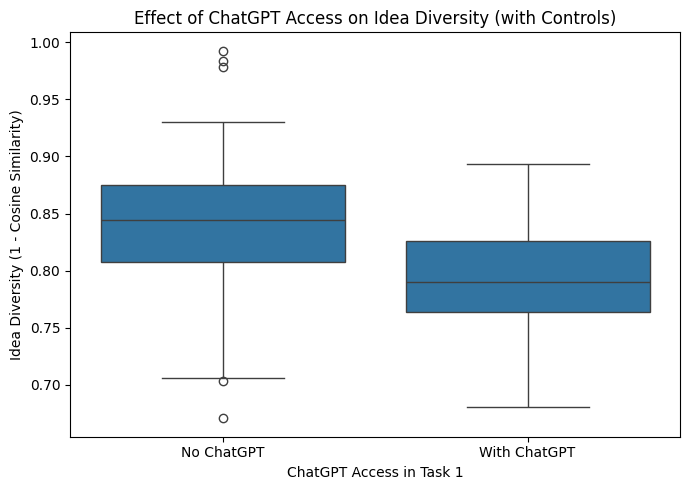

In [13]:
# Diversity + Task1_Access + Controls

# define control variables
predictors = [
    'Task1_ChatGPT_Access', 
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# drop N/A
df = df_survey_ideas.dropna(subset=predictors + ["idea_diversity"])

# design OLS regression
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["idea_diversity"]
model = sm.OLS(y, X).fit()

print(model.summary())

# box plot showing differences
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Interaction", y="idea_diversity", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Access in Task 1")
plt.ylabel("Idea Diversity (1 - Cosine Similarity)")
plt.title("Effect of ChatGPT Access on Idea Diversity (with Controls)")
plt.tight_layout()
plt.show()

                            OLS Regression Results                            
Dep. Variable:         idea_diversity   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     3.394
Date:                Sat, 12 Apr 2025   Prob (F-statistic):            0.00179
Time:                        22:21:37   Log-Likelihood:                 156.55
No. Observations:                 105   AIC:                            -295.1
Df Residuals:                      96   BIC:                            -271.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

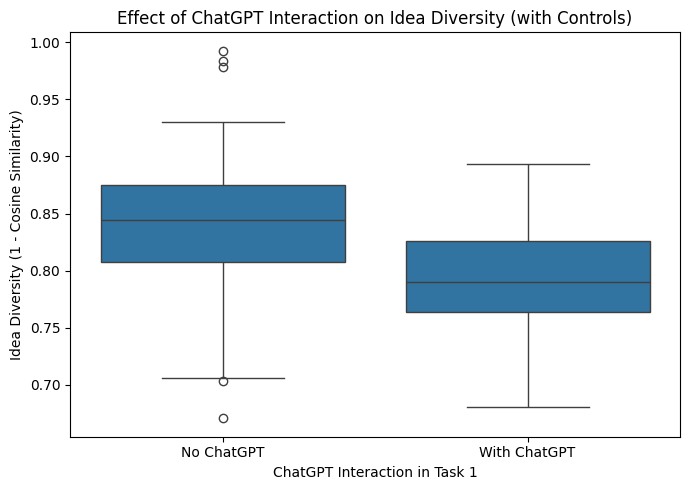

In [14]:
# Diversity + Task1_Interaction + Controls

# define control variables
predictors = [
    'Task1_ChatGPT_Interaction', 
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# drop N/A
df = df_survey_ideas.dropna(subset=predictors + ["idea_diversity"])

# design OLS regression
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["idea_diversity"]
model = sm.OLS(y, X).fit()

print(model.summary())

# box plot showing differences
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Interaction", y="idea_diversity", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 1")
plt.ylabel("Idea Diversity (1 - Cosine Similarity)")
plt.title("Effect of ChatGPT Interaction on Idea Diversity (with Controls)")
plt.tight_layout()
plt.show()

                             OLS Regression Results                             
Dep. Variable:     idea_clean_diversity   R-squared:                       0.106
Model:                              OLS   Adj. R-squared:                  0.032
Method:                   Least Squares   F-statistic:                     1.424
Date:                  Sat, 12 Apr 2025   Prob (F-statistic):              0.196
Time:                          22:21:37   Log-Likelihood:                 154.16
No. Observations:                   105   AIC:                            -290.3
Df Residuals:                        96   BIC:                            -266.4
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
cons

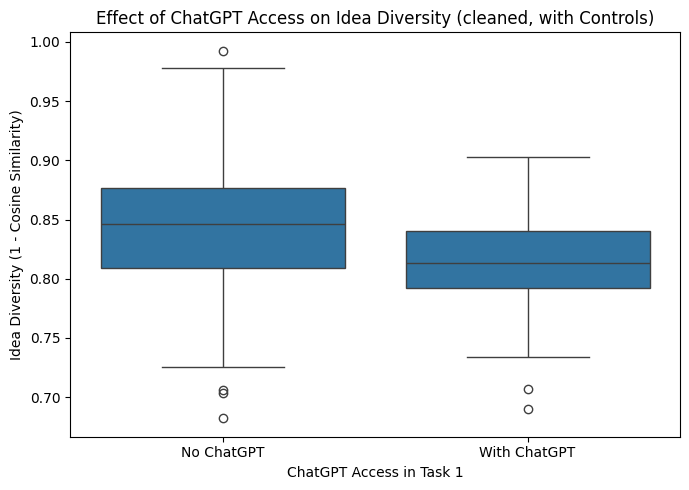

In [15]:
# Cleaned Diversity + Task1_Access + Controls

# define control variables
predictors = [
    'Task1_ChatGPT_Access', 
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# drop N/A
df = df_survey_ideas.dropna(subset=predictors + ["idea_clean_diversity"])

# design OLS regression
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["idea_clean_diversity"]
model = sm.OLS(y, X).fit()

print(model.summary())

# box plot showing differences
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Interaction", y="idea_clean_diversity", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Access in Task 1")
plt.ylabel("Idea Diversity (1 - Cosine Similarity)")
plt.title("Effect of ChatGPT Access on Idea Diversity (cleaned, with Controls)")
plt.tight_layout()
plt.show()

                             OLS Regression Results                             
Dep. Variable:     idea_clean_diversity   R-squared:                       0.126
Model:                              OLS   Adj. R-squared:                  0.053
Method:                   Least Squares   F-statistic:                     1.723
Date:                  Sat, 12 Apr 2025   Prob (F-statistic):              0.103
Time:                          22:21:37   Log-Likelihood:                 155.31
No. Observations:                   105   AIC:                            -292.6
Df Residuals:                        96   BIC:                            -268.7
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co

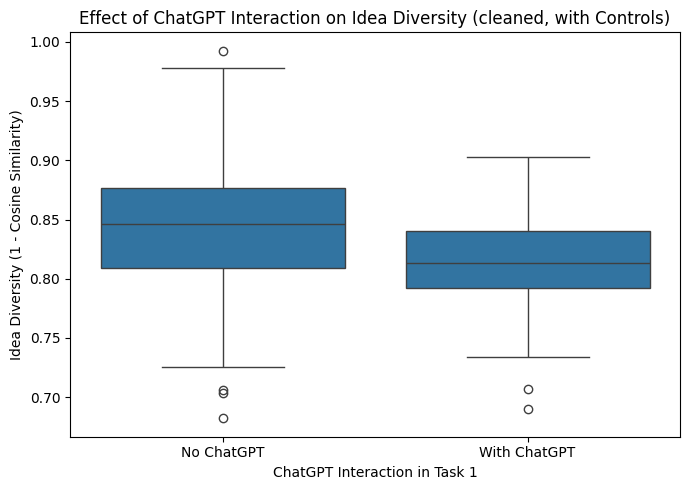

In [16]:
# Cleaned Diversity + Task1_Interaction + Controls

# define control variables
predictors = [
    'Task1_ChatGPT_Interaction', 
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# drop N/A
df = df_survey_ideas.dropna(subset=predictors + ["idea_clean_diversity"])

# design OLS regression
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["idea_clean_diversity"]
model = sm.OLS(y, X).fit()

print(model.summary())

# box plot showing differences
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task1_ChatGPT_Interaction", y="idea_clean_diversity", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 1")
plt.ylabel("Idea Diversity (1 - Cosine Similarity)")
plt.title("Effect of ChatGPT Interaction on Idea Diversity (cleaned, with Controls)")
plt.tight_layout()
plt.show()